# Testing co-location rate and spatial co-location rate

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from colocation.wang_colocation import WangColocation
from scipy.special import expit
from math import dist
from tqdm import tqdm
import skmob

## Functions

In [2]:
def discrete_x_delta(a, b):
    """
    Checks that locationID is the same.
    """
    return a==b

In [3]:
def trace_x_delta(a, b, x_tolerance):
    """
    Checks that the distance between two locations is within a certain tolerance.
    """
    return dist(a, b) <= x_tolerance

In [4]:
def t_delta(a, b, t_tolerance):
    """
    Checks that the difference between two times is within a certain tolerance.
    """
    return np.heaviside(t_tolerance - abs(a-b), 1)

In [5]:
def is_valid_time_diff(row):
    t1 = row["time_x"]
    t2 = row["time_y"]
    t_tol = row["t_tol"]
    return t_delta(t1, t2, t_tol)

In [6]:
def get_scol_points_discrete(users: pd.DataFrame) -> pd.DataFrame:
    user_x = users.loc[users["userID"]=="x", :]
    user_y = users.loc[users["userID"]=="y", :]
    
    matching = user_x.merge(user_y, on=["locationID"])
    return matching

In [7]:
def get_col_points_discrete(users: pd.DataFrame,
                            t_tolerance: float = 1.0) -> pd.DataFrame:
    scol_points = get_scol_points_discrete(users)
    scol_points["t_tol"] = t_tolerance
    scol_points["is_time_match"] = scol_points.apply(is_valid_time_diff, axis=1)
    col_points = scol_points.loc[scol_points["is_time_match"]==1, :]
    return col_points

In [8]:
def get_user_list_of_dicts(users: pd.DataFrame, userID: str) -> list[dict]:
    user_data = users.loc[users["userID"]==userID, :]
    user_data = user_data.to_dict("records")
    return user_data

In [9]:
def get_scol_points_traces(users: pd.DataFrame,
                           x_tolerance: float = 1.0) -> pd.DataFrame:
    user_x = get_user_list_of_dicts(users, "x")
    user_y = get_user_list_of_dicts(users, "y")

    scol_points = []

    for x_record in user_x:
        for y_record in user_y:
            d1 = x_record.copy()
            d2 = y_record.copy()
            
            x_coords = (x_record["x"], x_record["y"])
            y_coords = (y_record["x"], y_record["y"])

            if trace_x_delta(x_coords, y_coords, x_tolerance):
                scol_points.extend([d1, d2])

    scol_points = pd.DataFrame(scol_points)
    return scol_points

In [10]:
def get_col_points_traces(users: pd.DataFrame,
                          t_tolerance: float = 1.0,
                          x_tolerance: float = 1.0) -> pd.DataFrame:
    user_x = get_user_list_of_dicts(users, "x")
    user_y = get_user_list_of_dicts(users, "y")

    scol_points = []

    for x_record in user_x:
        for y_record in user_y:
            d1 = x_record.copy()
            d2 = y_record.copy()
            
            x_coords = (x_record["x"], x_record["y"])
            y_coords = (y_record["x"], y_record["y"])
            x_time = x_record["time"]
            y_time = y_record["time"]

            condition1 = trace_x_delta(x_coords, y_coords, x_tolerance)
            condition2 = t_delta(x_time, y_time, t_tolerance)

            if condition1 and condition2:
                scol_points.extend([d1, d2])

    scol_points = pd.DataFrame(scol_points)
    return scol_points

In [11]:
def make_traces(users: pd.DataFrame,
                t_interval: float = 1.0) -> pd.DataFrame:
    all_data = []

    for userID in users["userID"].unique():
        # Filter to specific user
        user_data = users.loc[users["userID"]==userID, :]
        
        # Create a list of missing times
        user_times = set(user_data["time"].unique())
        start = min(user_times)
        end = max(user_times)
        all_times = set(np.arange(start, end, t_interval))
        missing_times = list(all_times - user_times)

        for missing_time in missing_times:
            d = {"userID": userID,
                 "locationID": np.nan,
                 "time": missing_time,
                 "x": np.nan,
                 "y": np.nan}
            user_data = pd.concat([user_data, pd.DataFrame([d])])

        user_data = user_data.sort_values(by="time")
        user_data["x"] = user_data["x"].interpolate()
        user_data["y"] = user_data["y"].interpolate()

        all_data.append(user_data)

    all_data = pd.concat(all_data)
    return all_data

In [12]:
def find_col(user1: pd.DataFrame, user2: pd.DataFrame) -> pd.DataFrame:
    matching = user1.merge(user2, on=["x", "y", "time"])
    return matching

In [13]:
def find_scol(user1: pd.DataFrame, user2: pd.DataFrame) -> pd.DataFrame:
    matching = user1.merge(user2, on=["x", "y"])
    return matching

In [14]:
def make_traj_3d(plotting_data: pd.DataFrame, save_path: str = "",
                 calculate_scol: bool = False, 
                 calculate_col: bool = True) -> None:
    labels = None if (calculate_col or calculate_scol) else "locationID"
    fig1 = px.line_3d(plotting_data, x="x", y="y", z="time",
                      text=labels, color="userID",
                      color_discrete_sequence=px.colors.qualitative.T10)

    user_x = plotting_data.loc[plotting_data["userID"]=="x", :]
    user_y = plotting_data.loc[plotting_data["userID"]=="y", :]

    col = find_col(user_x, user_y) if calculate_col else []
    scol = find_scol(user_x, user_y) if calculate_scol else []

    d = fig1.data

    if len(col) > 0:
        # Adding points for spatiotemporal co-locaation
        fig2 = px.scatter_3d(col, x="x", y="y", z="time",
                             text="locationID_x", opacity=0.5,
                             color_discrete_sequence=px.colors.qualitative.T10)
        d = d + fig2.data
    if len(scol) > 0:
        # Adding points for spatial co-locaation
        fig3 = px.scatter_3d(scol, x="x", y="y", z="time_x", 
                             text="locationID_x", opacity=0.5,
                             color_discrete_sequence=px.colors.qualitative.T10)
        fig4 = px.scatter_3d(scol, x="x", y="y", z="time_y", 
                             text="locationID_y", opacity=0.5,
                             color_discrete_sequence=px.colors.qualitative.T10)
        d = d + fig3.data + fig4.data
    
    fig = go.Figure(data = d)

    camera = {"eye": {"x": -2, "y": -1.5, "z": 1}}
        
    fig.update_layout(scene=dict(xaxis_title="x",
                                 yaxis_title="y",
                                 zaxis_title="time"),
                      scene_camera=camera,
                      margin=dict(l=5, r=5, t=5, b=5),
                      width=600, height=600)

    if save_path.endswith(".html"):
        fig.write_html(save_path)
    if save_path.endswith(".pdf"):
        fig.write_image(save_path)

    return fig

In [15]:
def make_traj_animation(plotting_data: pd.DataFrame, save_path: str= "") -> None:
    xs = plotting_data["x"]
    ys = plotting_data["y"]
    fig = px.scatter(plotting_data, x="x", y="y",
                 animation_frame="time", animation_group="userID", color="userID",
                 range_x=[min(xs), max(xs)], range_y=[min(ys), max(ys)])

    if save_path.endswith(".html"):
        fig.write_html(save_path)

    fig.show()

In [16]:
def curve(row):
    x = row["x"]
    numerator = 1
    denominator = 1 + (x/(1-x))**(-1)
    return numerator / denominator

In [17]:
def make_noisy_traces(original_traces: pd.DataFrame,
                      sample_variance: float = 1.0) -> pd.DataFrame:
    # Assume unbiased noise
    sample_mean = np.array([0, 0])
    sample_cov = np.array([[sample_variance, 0],
                           [0, sample_variance]])
    # N x 2 because we want a noise for x and a noise for y
    gaussian_sample = np.random.multivariate_normal(sample_mean, sample_cov, len(original_traces))
    noisy_traces = traces.copy()
    noisy_traces["x"] += gaussian_sample[:, 0]
    noisy_traces["y"] += gaussian_sample[:, 1]
    return noisy_traces

## Create datasets

## Dataset

This dataset will collect data with uniform frequency.
However, instead of collecting $x-y$ coordinates for the individuals, the data will consist of specific location IDs and each location ID will have a given set of $x-y$ coordinates.

In [18]:
locations = [{"locationID": "0", "x": 0, "y": 0},
             {"locationID": "1", "x": 4, "y": 2},
             {"locationID": "2", "x": 6, "y": 8},
             {"locationID": "3", "x": 14, "y": 4},
             {"locationID": "4", "x": 8, "y": 16},
             {"locationID": "5", "x": 2, "y": 10},
             {"locationID": "6", "x": 16, "y": 20},
             {"locationID": "7", "x": 10, "y": 14},
             {"locationID": "8", "x": 18, "y": 6}]
locations = pd.DataFrame(locations)
locations.head()

locationID   x   y
0          0   0   0
1          1   4   2
2          2   6   8
3          3  14   4
4          4   8  16

In [19]:
# fig1 = px.scatter(locations,
#                   x="x", y="y", 
#                   text="locationID")
# fig2 = px.scatter(locations,
#                   x="x", y="y",
#                   opacity=0.5)
# fig2.update_traces(marker=dict(size=20))
# fig = go.Figure(data=fig1.data+fig2.data)
# fig.update_layout(margin=dict(l=20, r=20, t=20, b=20), 
#                   width=600, height=600,
#                   xaxis_title="x",
#                   yaxis_title="y")
# fig.update_traces(textposition="top center")
# fig.show()
# fig.write_image("figures/sensor_locations.pdf")

In [20]:
locations.to_csv("data/locations.csv", index=False)

In [21]:
data = [{"userID": "x", "locationID": "0", "time": 0},
        {"userID": "y", "locationID": "0", "time": 0},
        {"userID": "x", "locationID": "1", "time": 5},
        {"userID": "y", "locationID": "1", "time": 6},
        {"userID": "x", "locationID": "2", "time": 8},
        {"userID": "y", "locationID": "4", "time": 10},
        {"userID": "x", "locationID": "6", "time": 11},
        {"userID": "y", "locationID": "3", "time": 12},
        {"userID": "x", "locationID": "3", "time": 15},
        {"userID": "y", "locationID": "1", "time": 15},
        {"userID": "y", "locationID": "7", "time": 18},
        {"userID": "x", "locationID": "0", "time": 20},
        {"userID": "y", "locationID": "8", "time": 20},
        {"userID": "x", "locationID": "0", "time": 22},
        {"userID": "x", "locationID": "3", "time": 25}]
data = pd.DataFrame(data)
data.head()

userID locationID  time
0      x          0     0
1      y          0     0
2      x          1     5
3      y          1     6
4      x          2     8

In [22]:
data.to_csv("data/data.csv", index=False)

In [23]:
plotting_data = pd.merge(left=data, right=locations, on="locationID", how="left")
plotting_data.head()

userID locationID  time  x  y
0      x          0     0  0  0
1      y          0     0  0  0
2      x          1     5  4  2
3      y          1     6  4  2
4      x          2     8  6  8

## Plot trajectories

In [24]:
plotting_data

userID locationID  time   x   y
0       x          0     0   0   0
1       y          0     0   0   0
2       x          1     5   4   2
3       y          1     6   4   2
4       x          2     8   6   8
5       y          4    10   8  16
6       x          6    11  16  20
7       y          3    12  14   4
8       x          3    15  14   4
9       y          1    15   4   2
10      y          7    18  10  14
11      x          0    20   0   0
12      y          8    20  18   6
13      x          0    22   0   0
14      x          3    25  14   4

In [25]:
user_x = plotting_data.loc[plotting_data["userID"]=="x", :]
user_y = plotting_data.loc[plotting_data["userID"]=="y", :]

In [26]:
base_fig = make_traj_3d(plotting_data, calculate_col=False, calculate_scol=False, save_path="figures/plotly_trajectory.pdf")
# base_fig.show()

## Identifying co-location points

In [27]:
# col_fig = make_traj_3d(plotting_data, save_path="figures/col.pdf")
# scol_fig = make_traj_3d(plotting_data, calculate_scol=True, save_path="figures/scol.pdf")

In [28]:
# scol_fig.show()

In [29]:
# col_fig.show()

### Spatial Co-Location

In [30]:
scol_points = get_scol_points_discrete(plotting_data)

In [31]:
scol_points

userID_x locationID  time_x  x_x  y_x userID_y  time_y  x_y  y_y
0        x          0       0    0    0        y       0    0    0
1        x          1       5    4    2        y       6    4    2
2        x          1       5    4    2        y      15    4    2
3        x          3      15   14    4        y      12   14    4
4        x          0      20    0    0        y       0    0    0
5        x          0      22    0    0        y       0    0    0
6        x          3      25   14    4        y      12   14    4

In [32]:
# fig1 = px.scatter_3d(scol_points, x="x_x", y="y_x", z="time_x", text="locationID")
# fig2 = px.scatter_3d(scol_points, x="x_y", y="y_y", z="time_y", text="locationID")
# fig3 = px.line_3d(plotting_data, x="x", y="y", z="time", color="userID")

# fig = go.Figure(data=(fig1.data + fig2.data + fig3.data))

# camera = {"eye": {"x": -2, "y": -1.5, "z": 1}}
    
# fig.update_layout(scene=dict(xaxis_title="x",
#                              yaxis_title="y",
#                              zaxis_title="time"),
#                   scene_camera=camera,
#                   margin=dict(l=5, r=5, t=5, b=5),
#                   width=600, height=600,
#                   showlegend=False)

# fig.write_image("figures/scol_discrete.pdf")

# fig.show()

### Co-Location

In [33]:
col_points = get_col_points_discrete(plotting_data)

In [34]:
col_points

userID_x locationID  time_x  x_x  y_x userID_y  time_y  x_y  y_y  t_tol  \
0        x          0       0    0    0        y       0    0    0    1.0   
1        x          1       5    4    2        y       6    4    2    1.0   

   is_time_match  
0            1.0  
1            1.0

In [35]:
# fig1 = px.scatter_3d(col_points, x="x_x", y="y_x", z="time_x", text="locationID")
# fig2 = px.scatter_3d(col_points, x="x_y", y="y_y", z="time_y", text="locationID")
# fig3 = px.line_3d(plotting_data, x="x", y="y", z="time", color="userID")

# fig = go.Figure(data=(fig1.data + fig2.data + fig3.data))

# camera = {"eye": {"x": -2, "y": -1.5, "z": 1}}
    
# fig.update_layout(scene=dict(xaxis_title="x",
#                              yaxis_title="y",
#                              zaxis_title="time"),
#                   scene_camera=camera,
#                   margin=dict(l=0, r=0, t=0, b=0),
#                   width=600, height=600,
#                   showlegend=False)

# fig.write_image("figures/col_discrete.pdf")

# fig.show()

## Converting to traces

In [36]:
traces = make_traces(plotting_data)

In [37]:
traces.head()

userID locationID  time    x    y
0      x          0   0.0  0.0  0.0
0      x        NaN   1.0  0.8  0.4
0      x        NaN   2.0  1.6  0.8
0      x        NaN   3.0  2.4  1.2
0      x        NaN   4.0  3.2  1.6

In [38]:
# base_fig = px.line_3d(traces, x="x", y="y", z="time", color="userID")
# base_fig.show()

Create `skmob` trajdataframe:

In [50]:
tdf = skmob.TrajDataFrame(traces, latitude="y", longitude="x", 
                          user_id="userID", datetime="time", crs={"init": None})

In [51]:
tdf["uid"] = tdf["uid"].map({"x": 1, "y": 2})

In [52]:
tdf = tdf.reset_index()

In [55]:
tdf.plot_trajectory()

/home/keiran/miniconda3/envs/coloc/lib/python3.12/site-packages/skmob/core/trajectorydataframe.py:569: UserWarning:

Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.

/home/keiran/miniconda3/envs/coloc/lib/python3.12/site-packages/skmob/core/trajectorydataframe.py:569: UserWarning:

If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.



In [80]:
def c(traj):
    ll = traj[["lat", "lng"]].values
    center_of_mass = np.mean(ll, axis=0)
    return np.mean(center_of_mass)

In [81]:
df = tdf.groupby("uid").apply(lambda x: c(x))

/tmp/ipykernel_599005/3751088622.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [82]:
df = pd.DataFrame(df).reset_index().rename(columns={0: "measure"})

In [83]:
type(df)

pandas.core.frame.DataFrame

In [84]:
df

uid   measure
0    1  5.942308
1    2  6.214286

## Identifying co-location in traces

In [39]:
scol_points = get_scol_points_traces(traces)

In [40]:
scol_points

userID locationID  time          x         y
0       x          0   0.0   0.000000  0.000000
1       y          0   0.0   0.000000  0.000000
2       x          0   0.0   0.000000  0.000000
3       y        NaN   1.0   0.666667  0.333333
4       x        NaN   1.0   0.800000  0.400000
..    ...        ...   ...        ...       ...
59      y          1   6.0   4.000000  2.000000
60      x        NaN  23.0   4.666667  1.333333
61      y          1  15.0   4.000000  2.000000
62      x          3  25.0  14.000000  4.000000
63      y          3  12.0  14.000000  4.000000

[64 rows x 5 columns]

In [41]:
# fig1 = px.scatter_3d(scol_points, x="x", y="y", z="time")
# fig2 = px.line_3d(plotting_data, x="x", y="y", z="time", color="userID")

# fig = go.Figure(data=(fig1.data + fig2.data))

# camera = {"eye": {"x": -2, "y": -1.5, "z": 1}}
    
# fig.update_layout(scene=dict(xaxis_title="x",
#                              yaxis_title="y",
#                              zaxis_title="time"),
#                   scene_camera=camera,
#                   margin=dict(l=5, r=5, t=5, b=5),
#                   width=600, height=600,
#                   showlegend=False)

# fig.write_image("figures/scol_traces.pdf")

# fig.show()

In [42]:
col_points = get_col_points_traces(traces)

In [43]:
col_points

userID locationID  time         x         y
0       x          0   0.0  0.000000  0.000000
1       y          0   0.0  0.000000  0.000000
2       x          0   0.0  0.000000  0.000000
3       y        NaN   1.0  0.666667  0.333333
4       x        NaN   1.0  0.800000  0.400000
5       y          0   0.0  0.000000  0.000000
6       x        NaN   1.0  0.800000  0.400000
7       y        NaN   1.0  0.666667  0.333333
8       x        NaN   1.0  0.800000  0.400000
9       y        NaN   2.0  1.333333  0.666667
10      x        NaN   2.0  1.600000  0.800000
11      y        NaN   2.0  1.333333  0.666667
12      x        NaN   2.0  1.600000  0.800000
13      y        NaN   3.0  2.000000  1.000000
14      x        NaN   3.0  2.400000  1.200000
15      y        NaN   3.0  2.000000  1.000000
16      x        NaN   3.0  2.400000  1.200000
17      y        NaN   4.0  2.666667  1.333333
18      x        NaN   4.0  3.200000  1.600000
19      y        NaN   4.0  2.666667  1.333333
20      x        NaN   4.0  3.200000  1.600000
21      y        NaN   5.0  3.333333  1.666667
22      x          1   5.0  4.000000  2.000000
23      y        NaN   5.0  3.333333  1.666667
24      x          1   5.0  4.000000  2.000000
25      y          1   6.0  4.000000  2.000000
26      x        NaN   7.0  5.333333  6.000000
27      y        NaN   7.0  5.000000  5.500000
28      x          2   8.0  6.000000  8.000000
29      y        NaN   8.0  6.000000  9.000000

In [44]:
# fig1 = px.scatter_3d(col_points, x="x", y="y", z="time")
# fig2 = px.line_3d(plotting_data, x="x", y="y", z="time", color="userID")

# fig = go.Figure(data=(fig1.data + fig2.data))

# camera = {"eye": {"x": -2, "y": -1.5, "z": 1}}
    
# fig.update_layout(scene=dict(xaxis_title="x",
#                              yaxis_title="y",
#                              zaxis_title="time"),
#                   scene_camera=camera,
#                   margin=dict(l=5, r=5, t=5, b=5),
#                   width=600, height=600,
#                   showlegend=False)

# fig.write_image("figures/col_traces.pdf")

# fig.show()

## Adding noise to traces

### Generate noise

In [45]:
noisy_traces = make_noisy_traces(traces)

In [46]:
# noisy_traces[["original_x", "original_y"]] = traces[["x", "y"]]
# fig1 = px.line_3d(traces, x="x", y="y", z="time", color="userID")
# fig2 = px.line_3d(noisy_traces, x="x", y="y", z="time", color="userID")

# fig = go.Figure(data=(fig1.data + fig2.data))

# camera = {"eye": {"x": -2, "y": -1.5, "z": 1}}
    
# fig.update_layout(scene=dict(xaxis_title="x",
#                              yaxis_title="y",
#                              zaxis_title="time"),
#                   scene_camera=camera,
#                   margin=dict(l=5, r=5, t=5, b=5),
#                   width=600, height=600,
#                   showlegend=False)

# fig.show()

In [47]:
noisy_traces["is_noisy"] = True
traces["is_noisy"] = False

In [48]:
combined_traces = pd.concat([traces, noisy_traces])

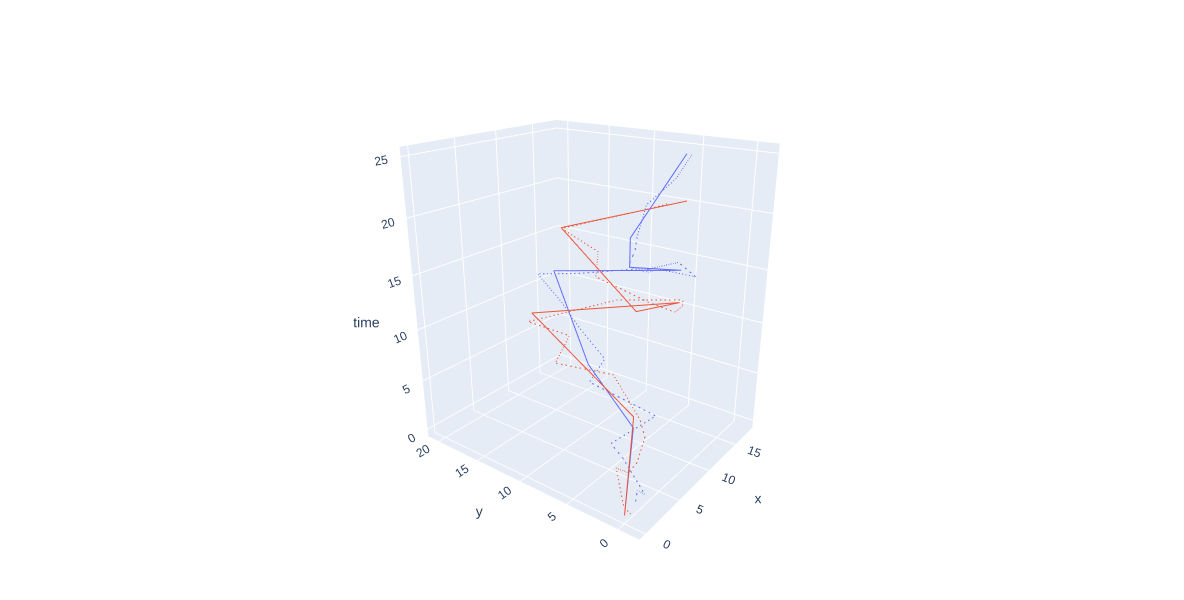

In [49]:
fig = px.line_3d(combined_traces, x="x", y="y", z="time", color="userID", line_dash="is_noisy")

camera = {"eye": {"x": -2, "y": -1.5, "z": 1}}
    
fig.update_layout(scene=dict(xaxis_title="x",
                             yaxis_title="y",
                             zaxis_title="time"),
                  scene_camera=camera,
                  margin=dict(l=5, r=5, t=5, b=5),
                  width=600, height=600,
                  showlegend=False)

fig.show()

In [50]:
col_points = get_col_points_traces(noisy_traces)

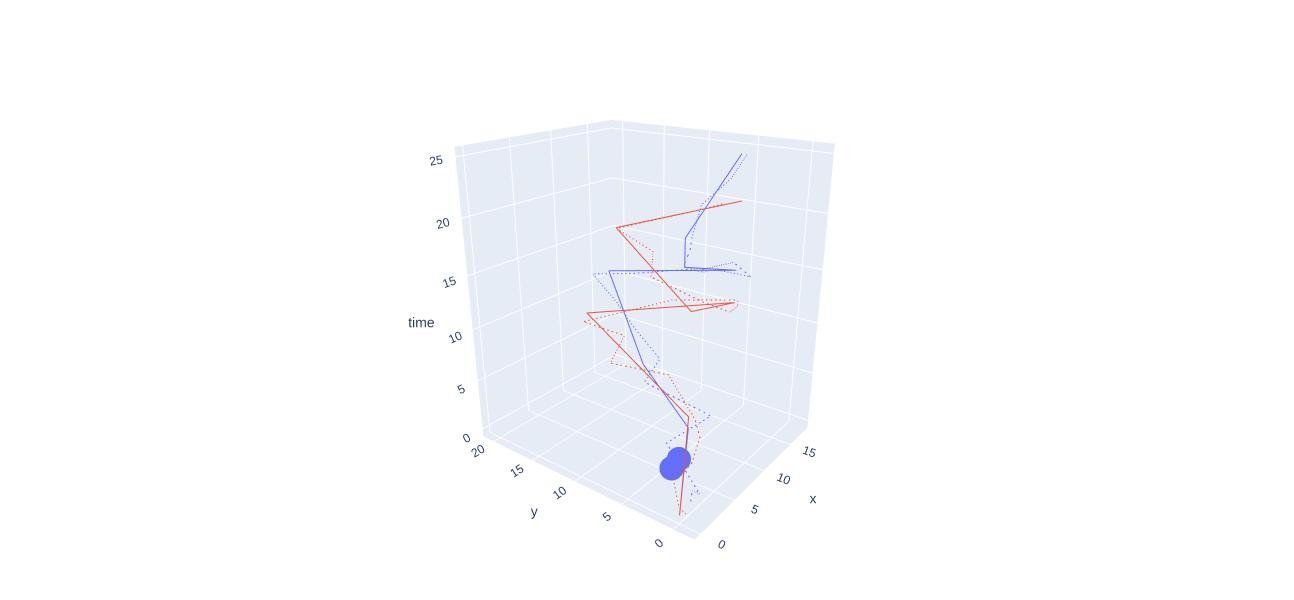

In [51]:
fig1 = px.scatter_3d(col_points, x="x", y="y", z="time")
fig2 = px.line_3d(combined_traces, x="x", y="y", z="time", color="userID", line_dash="is_noisy")

fig = go.Figure(data=(fig1.data + fig2.data))

camera = {"eye": {"x": -2, "y": -1.5, "z": 1}}
    
fig.update_layout(scene=dict(xaxis_title="x",
                             yaxis_title="y",
                             zaxis_title="time"),
                  scene_camera=camera,
                  margin=dict(l=5, r=5, t=5, b=5),
                  width=600, height=600,
                  showlegend=False)

fig.write_image("figures/noisy_col_traces.pdf")

fig.show()

## Monte carlo with noise

In [52]:
# N = 1000

# col_points = get_col_points_traces(traces)
# n_col_true = len(col_points)
# print(n_col_true)

# data = []

# for i in tqdm(range(N)):
#     d = {"id": i}
#     noisy_traces = make_noisy_traces(traces)
#     col_points = get_col_points_traces(noisy_traces)
#     n_col_trial = len(col_points)
#     d["pc_col_diff"] = (n_col_true - n_col_trial) / n_col_true * 100

#     data.append(d)

# data = pd.DataFrame(data)

In [53]:
# fig = px.violin(data, x="pc_col_diff")
# fig.show()

In [54]:
x_tolerances = [0.5*i for i in range(1, 11)]
t_tolerances = x_tolerances.copy()

In [55]:
from itertools import product

In [56]:
combos = list(product(x_tolerances, t_tolerances))

In [57]:
# Run combos with original traces
original_data = {}

for combo in tqdm(combos):
    col_points = get_col_points_traces(traces,
                                       x_tolerance=combo[0],
                                       t_tolerance=combo[1])
    n_col_true = len(col_points)
    original_data[combo] = n_col_true

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 208.93it/s]


In [58]:
N = 1000
data = []

for _ in tqdm(range(N)):
    for combo in combos:
        d = {"x_tolerance": combo[0], "t_tolerance": combo[1]}
        noisy_traces = make_noisy_traces(traces)
        col_points = get_col_points_traces(noisy_traces,
                                           x_tolerance=combo[0],
                                           t_tolerance=combo[1])
        n_col_trial = len(col_points)
        true = original_data[combo]
        d["pc_col_diff"] = (n_col_trial - true) / true * 100
                
        data.append(d)

data = pd.DataFrame(data)

100%|█████████████████████████████████████████████████████████████████| 1000/1000 [08:03<00:00,  2.07it/s]


In [59]:
data.shape

(100000, 3)

In [60]:
data.head()

x_tolerance  t_tolerance  pc_col_diff
0          0.5          0.5       -100.0
1          0.5          1.0        -87.5
2          0.5          1.5        -75.0
3          0.5          2.0       -100.0
4          0.5          2.5        -87.5

<Figure size 640x480 with 0 Axes>

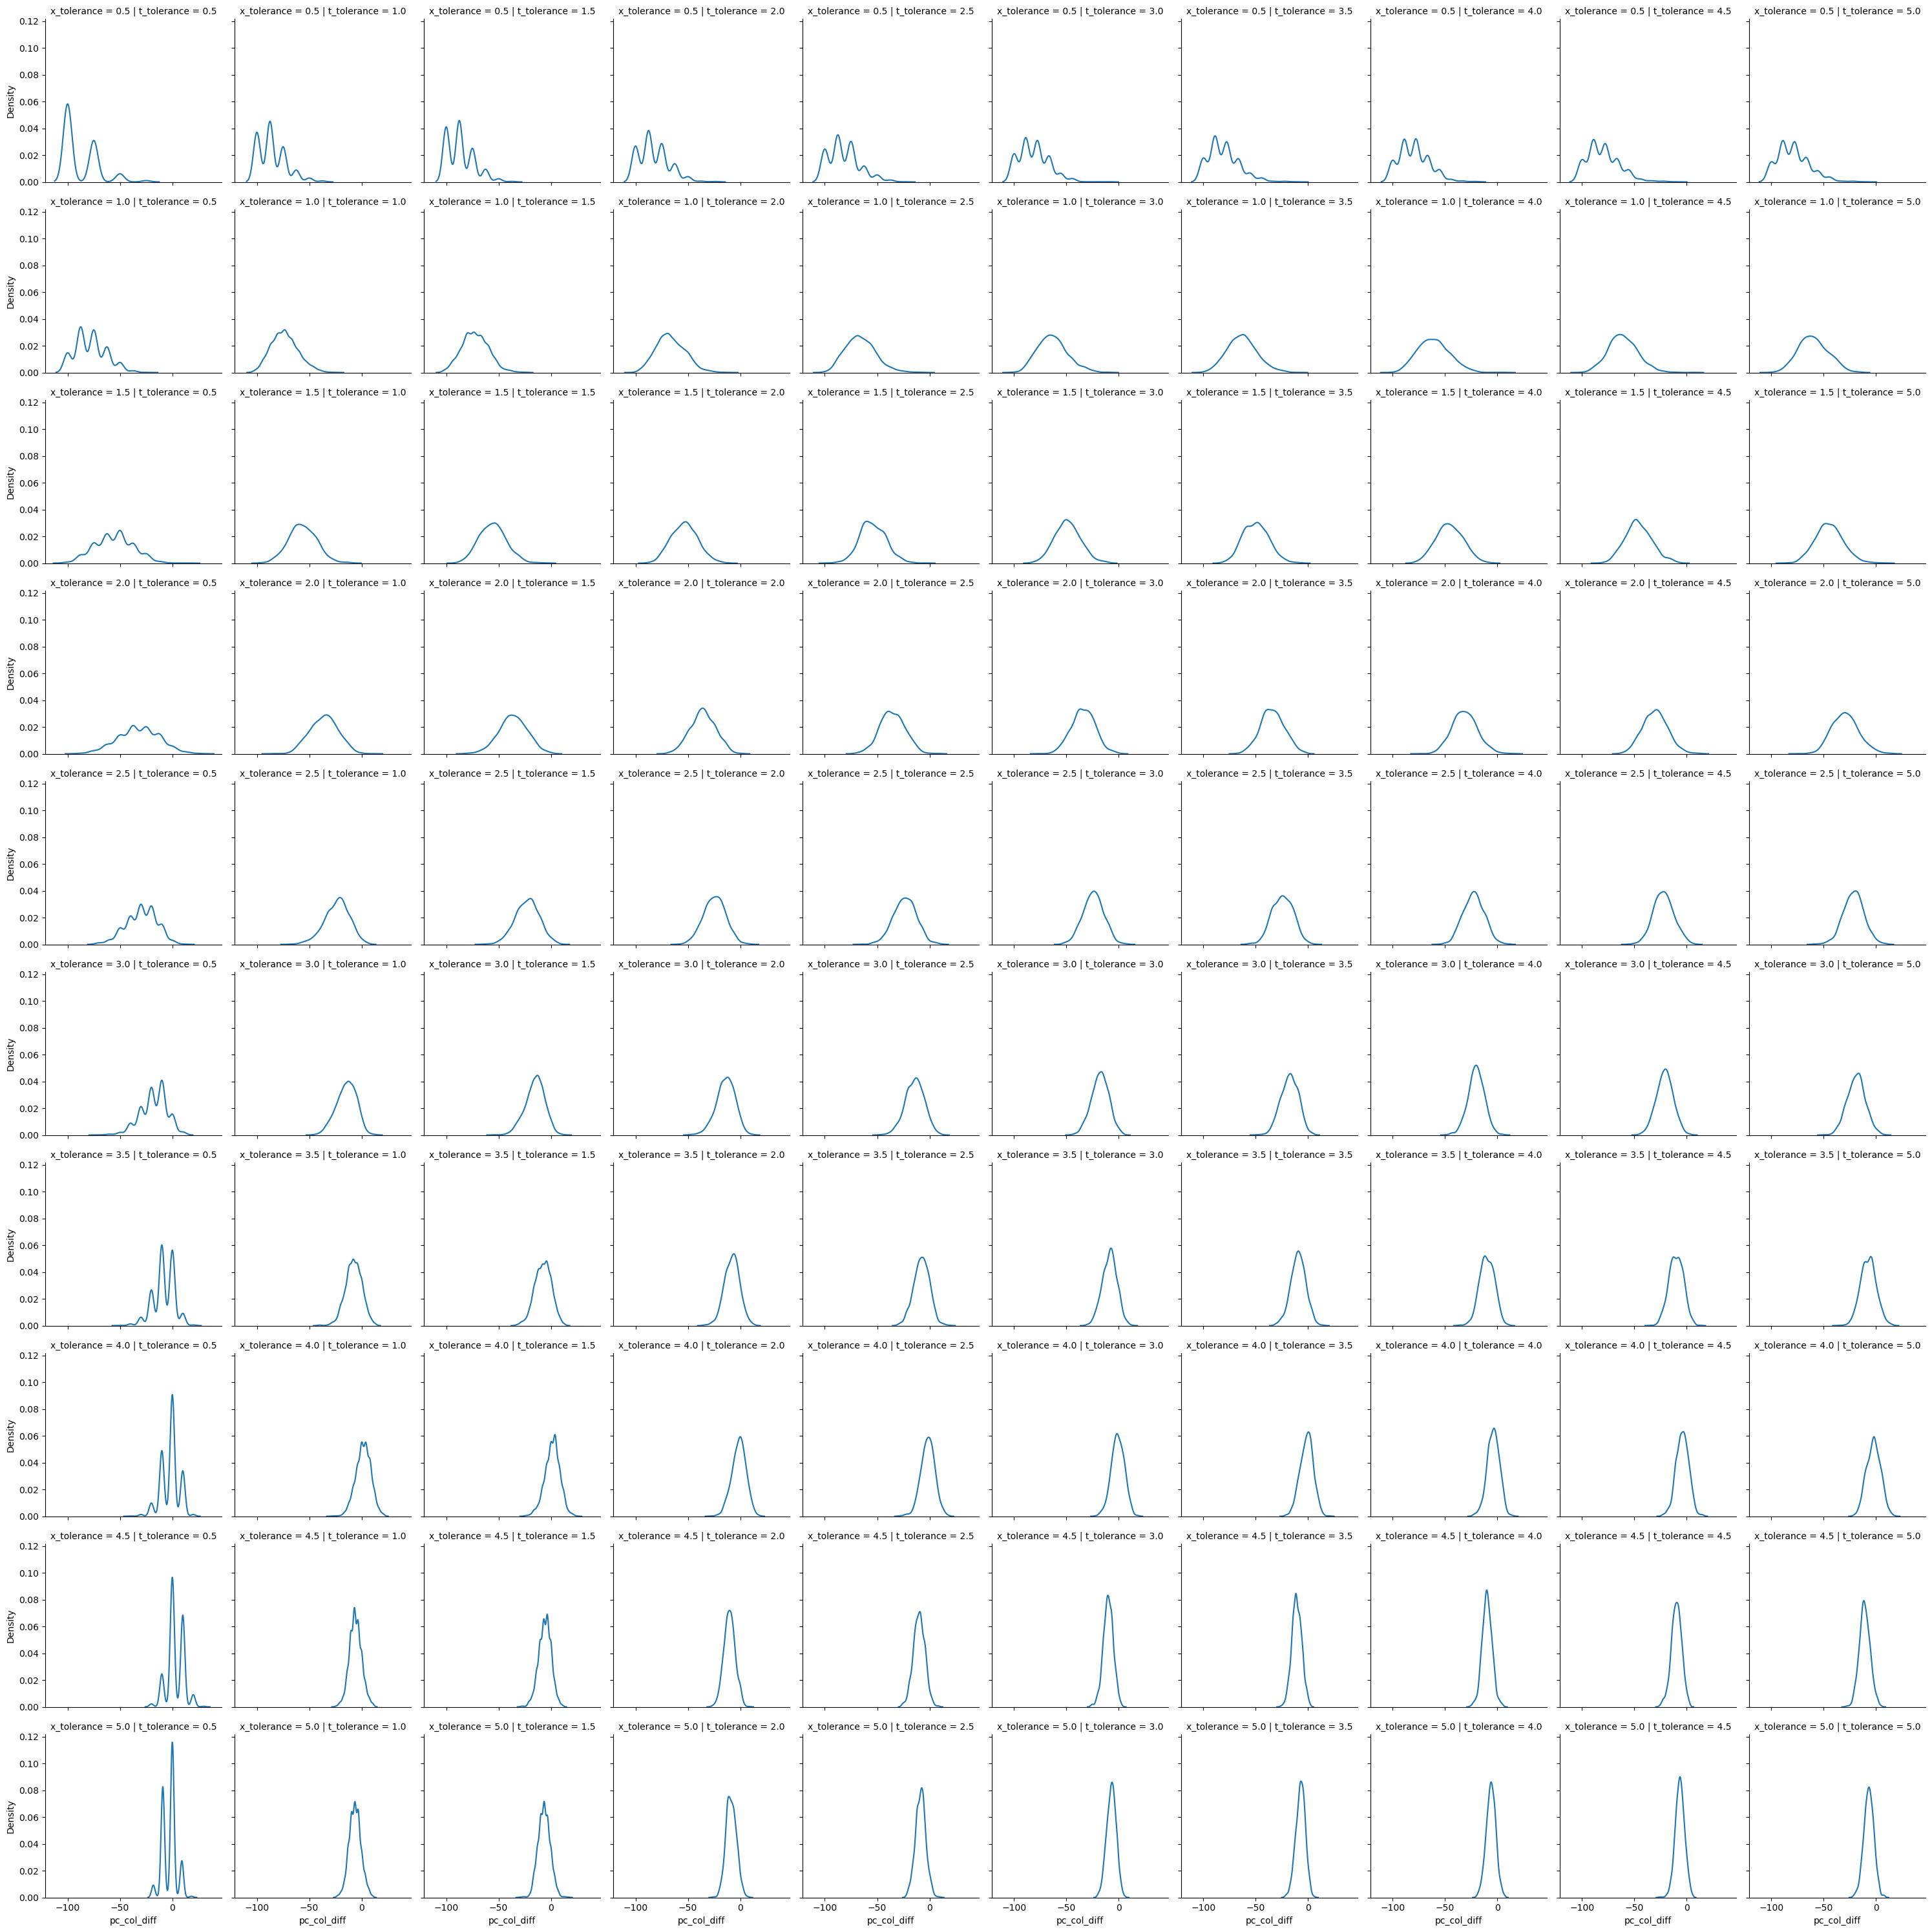

In [61]:
plt.figure()
g = sns.FacetGrid(data, col="t_tolerance",  row="x_tolerance")
g.map(sns.kdeplot, "pc_col_diff")
plt.savefig("figures/percentage_error_colocation_rate.pdf")
plt.show()

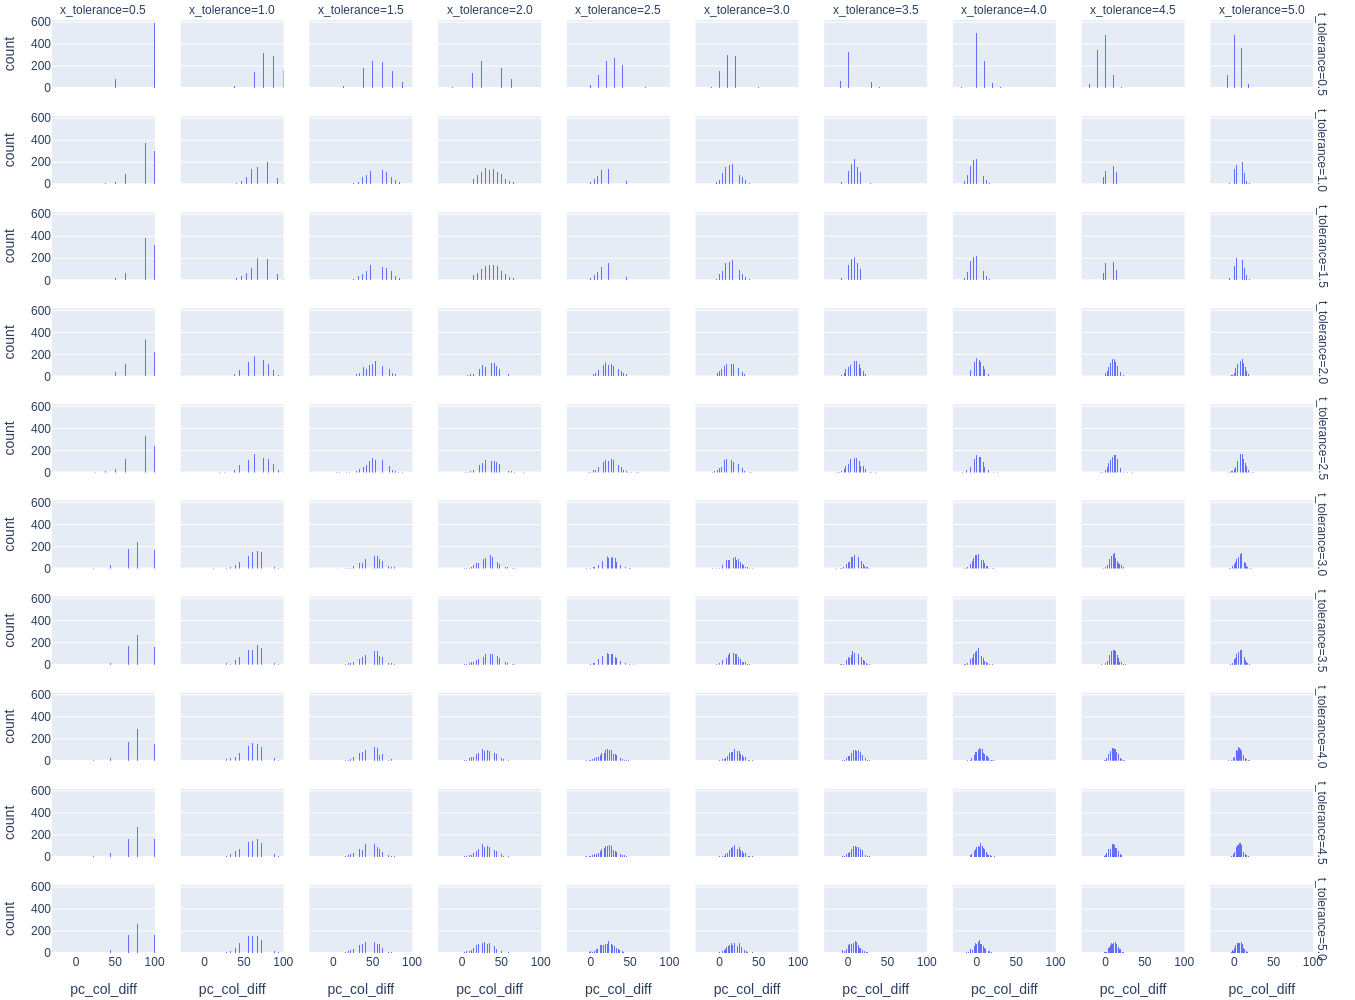

In [62]:
fig = px.histogram(data, x="pc_col_diff",
                   facet_row="t_tolerance", facet_col="x_tolerance",
                   width = 1000, height=1000)

fig.update_layout(margin=dict(l=5, r=5, t=20, b=5))

fig.write_html("figures/percentage_error_colocation_rate.html")
fig.write_image("figures/percentage_error_colocation_rate.pdf")
fig.show()

In [63]:
data.min()

x_tolerance     0.5
t_tolerance     0.5
pc_col_diff   -30.0
dtype: float64

In [64]:
extract = data.loc[data["pc_col_diff"]<0, :]

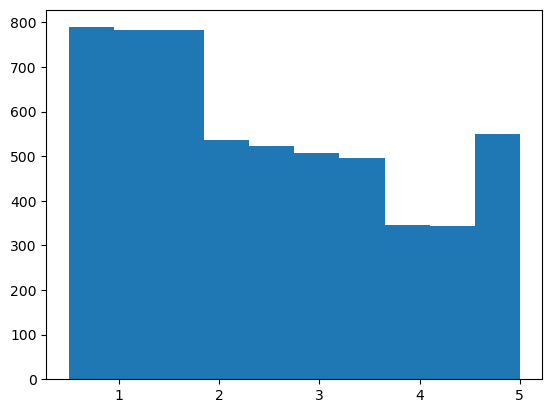

In [65]:
plt.hist(extract["t_tolerance"])
plt.show()

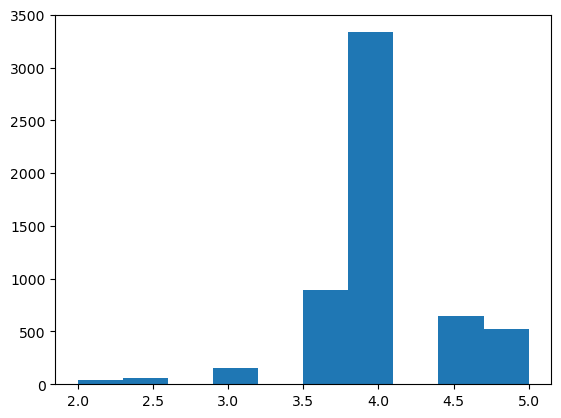

In [66]:
plt.hist(extract["x_tolerance"])
plt.show()

In [67]:
t_tolerances = sorted(data["t_tolerance"].unique())
x_tolerances = sorted(data["x_tolerance"].unique())

In [68]:
medians = np.zeros((len(t_tolerances), len(x_tolerances)))
medians

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [69]:
df = []

In [70]:
for i, t in enumerate(t_tolerances):
    for j, x in enumerate(x_tolerances):
        reduced_data = data.loc[(data["x_tolerance"]==x) & (data["t_tolerance"]==t), :]
        medians[i, j] = reduced_data["pc_col_diff"].median()
        d = {"x_tolerance": x, "t_tolerance": t, "median": reduced_data["pc_col_diff"].median()}
        df.append(d)

In [71]:
df = pd.DataFrame(df)
df.head()

x_tolerance  t_tolerance  median
0          0.5          0.5   100.0
1          1.0          0.5    75.0
2          1.5          0.5    50.0
3          2.0          0.5    37.5
4          2.5          0.5    30.0

In [72]:
medians

array([[100.        ,  75.        ,  50.        ,  37.5       ,
         30.        ,  20.        ,  10.        ,   0.        ,
          0.        ,   0.        ],
       [ 87.5       ,  73.33333333,  57.89473684,  35.        ,
         22.72727273,  12.5       ,   8.        ,   0.        ,
          6.89655172,   6.4516129 ],
       [ 87.5       ,  73.33333333,  57.89473684,  35.        ,
         22.72727273,  16.66666667,   8.        ,   0.        ,
          6.89655172,   6.4516129 ],
       [ 87.5       ,  68.75      ,  54.16666667,  37.03703704,
         22.58064516,  14.70588235,   8.10810811,   2.56410256,
         10.63829787,   8.        ],
       [ 87.5       ,  68.75      ,  54.16666667,  33.33333333,
         22.58064516,  14.70588235,   8.10810811,   2.56410256,
         10.63829787,   8.        ],
       [ 77.77777778,  61.11111111,  48.14814815,  33.33333333,
         23.07692308,  17.77777778,   8.33333333,   0.        ,
          9.83606557,   7.8125    ],
       [ 7

In [73]:
medians = pd.DataFrame(medians.T, columns=t_tolerances, index=x_tolerances)
medians

0.5        1.0        1.5        2.0        2.5        3.0        3.5  \
0.5  100.0  87.500000  87.500000  87.500000  87.500000  77.777778  77.777778   
1.0   75.0  73.333333  73.333333  68.750000  68.750000  61.111111  66.666667   
1.5   50.0  57.894737  57.894737  54.166667  54.166667  48.148148  48.148148   
2.0   37.5  35.000000  35.000000  37.037037  33.333333  33.333333  36.363636   
2.5   30.0  22.727273  22.727273  22.580645  22.580645  23.076923  23.076923   
3.0   20.0  12.500000  16.666667  14.705882  14.705882  17.777778  17.777778   
3.5   10.0   8.000000   8.000000   8.108108   8.108108   8.333333   8.333333   
4.0    0.0   0.000000   0.000000   2.564103   2.564103   0.000000   2.000000   
4.5    0.0   6.896552   6.896552  10.638298  10.638298   9.836066   9.836066   
5.0    0.0   6.451613   6.451613   8.000000   8.000000   7.812500   7.812500   

           4.0        4.5        5.0  
0.5  77.777778  77.777778  77.777778  
1.0  61.111111  61.111111  61.111111  
1.5  48.148148  44.444444  44.444444  
2.0  29.411765  29.411765  29.411765  
2.5  21.428571  21.428571  20.930233  
3.0  21.153846  21.153846  18.867925  
3.5  10.909091  10.909091   7.142857  
4.0   3.389831   5.084746   3.225806  
4.5  10.000000  10.000000  11.688312  
5.0   6.756757   6.756757   6.097561

## Exploring the relationship between `x_tolerance`, `t_tolerance` and average error (median?)

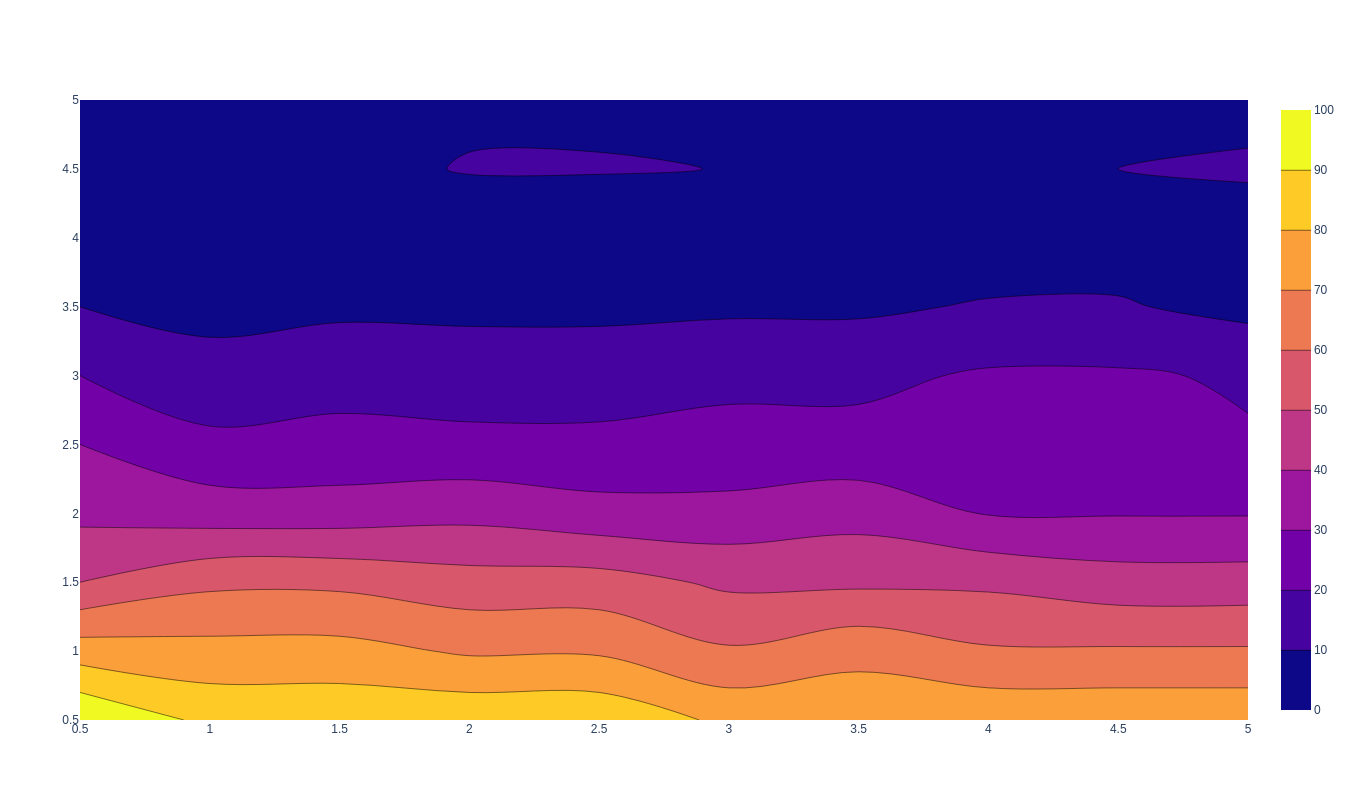

In [74]:
fig = go.Figure(data =
    go.Contour(
        z=medians,
        x=medians.columns,
        y=medians.index
    ))
fig.update_layout(width=800, height=800)
fig.show()

In [62]:
median_tolerance_groupings = data.groupby(["x_tolerance", "t_tolerance"]).median()

In [69]:
median_tolerance_groupings

pc_col_diff
x_tolerance t_tolerance             
0.5         0.5           100.000000
            1.0            87.500000
            1.5            87.500000
            2.0            87.500000
            2.5            87.500000
...                              ...
5.0         3.0             7.812500
            3.5             7.812500
            4.0             6.756757
            4.5             6.756757
            5.0             7.317073

[100 rows x 1 columns]

In [71]:
medians = median_tolerance_groupings.unstack()

In [72]:
medians

pc_col_diff                                              \
t_tolerance         0.5        1.0        1.5        2.0        2.5   
x_tolerance                                                           
0.5               100.0  87.500000  87.500000  87.500000  87.500000   
1.0                75.0  73.333333  73.333333  68.750000  68.750000   
1.5                50.0  57.894737  57.894737  54.166667  54.166667   
2.0                37.5  35.000000  35.000000  37.037037  33.333333   
2.5                30.0  22.727273  22.727273  25.806452  22.580645   
3.0                20.0  16.666667  12.500000  14.705882  14.705882   
3.5                10.0   8.000000   8.000000   8.108108   8.108108   
4.0                 0.0   0.000000  -4.000000   0.000000   0.000000   
4.5                 0.0   6.896552   6.896552  10.638298  10.638298   
5.0                 0.0   6.451613   6.451613   8.000000   8.000000   

                                                                    
t_tolerance        3.0        3.5        4.0        4.5        5.0  
x_tolerance                                                         
0.5          77.777778  77.777778  77.777778  77.777778  77.777778  
1.0          61.111111  66.666667  61.111111  61.111111  61.111111  
1.5          48.148148  48.148148  44.444444  44.444444  44.444444  
2.0          33.333333  33.333333  32.352941  32.352941  29.411765  
2.5          23.076923  25.641026  21.428571  21.428571  20.930233  
3.0          17.777778  17.777778  21.153846  21.153846  18.867925  
3.5           8.333333   8.333333   9.090909  10.909091   7.142857  
4.0           0.000000   2.000000   3.389831   3.389831   1.612903  
4.5           9.836066   9.836066  10.000000  10.000000  10.389610  
5.0           7.812500   7.812500   6.756757   6.756757   7.317073

In [64]:
medians.columns = medians.columns.droplevel()
medians

t_tolerance    0.5        1.0        1.5        2.0        2.5        3.0  \
x_tolerance                                                                 
0.5          100.0  87.500000  87.500000  87.500000  87.500000  77.777778   
1.0           75.0  73.333333  73.333333  68.750000  68.750000  61.111111   
1.5           50.0  57.894737  57.894737  54.166667  54.166667  48.148148   
2.0           37.5  35.000000  35.000000  37.037037  33.333333  33.333333   
2.5           30.0  22.727273  22.727273  25.806452  22.580645  23.076923   
3.0           20.0  16.666667  12.500000  14.705882  14.705882  17.777778   
3.5           10.0   8.000000   8.000000   8.108108   8.108108   8.333333   
4.0            0.0   0.000000  -4.000000   0.000000   0.000000   0.000000   
4.5            0.0   6.896552   6.896552  10.638298  10.638298   9.836066   
5.0            0.0   6.451613   6.451613   8.000000   8.000000   7.812500   

t_tolerance        3.5        4.0        4.5        5.0  
x_tolerance                                              
0.5          77.777778  77.777778  77.777778  77.777778  
1.0          66.666667  61.111111  61.111111  61.111111  
1.5          48.148148  44.444444  44.444444  44.444444  
2.0          33.333333  32.352941  32.352941  29.411765  
2.5          25.641026  21.428571  21.428571  20.930233  
3.0          17.777778  21.153846  21.153846  18.867925  
3.5           8.333333   9.090909  10.909091   7.142857  
4.0           2.000000   3.389831   3.389831   1.612903  
4.5           9.836066  10.000000  10.000000  10.389610  
5.0           7.812500   6.756757   6.756757   7.317073

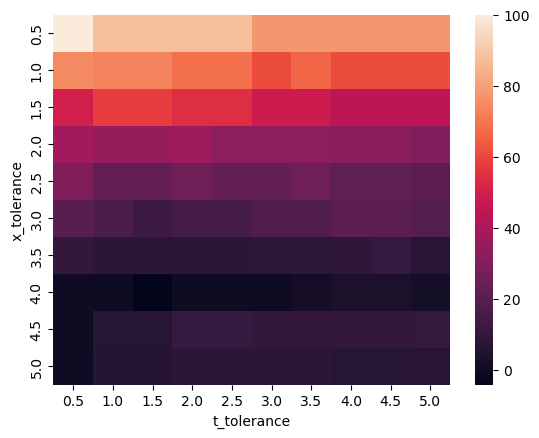

In [65]:
plt.figure()
sns.heatmap(medians)
plt.show()

In [66]:
log_medians = medians.transform(np.log)

In [68]:
log_medians

t_tolerance       0.5       1.0       1.5       2.0       2.5       3.0  \
x_tolerance                                                               
0.5          4.605170  4.471639  4.471639  4.471639  4.471639  4.353856   
1.0          4.317488  4.295015  4.295015  4.230477  4.230477  4.112694   
1.5          3.912023  4.058626  4.058626  3.992066  3.992066  3.874283   
2.0          3.624341  3.555348  3.555348  3.611918  3.506558  3.506558   
2.5          3.401197  3.123566  3.123566  3.250625  3.117093  3.138833   
3.0          2.995732  2.813411  2.525729  2.688248  2.688248  2.877949   
3.5          2.302585  2.079442  2.079442  2.092865  2.092865  2.120264   
4.0              -inf      -inf       NaN      -inf      -inf      -inf   
4.5              -inf  1.931022  1.931022  2.364460  2.364460  2.286056   
5.0              -inf  1.864330  1.864330  2.079442  2.079442  2.055725   

t_tolerance       3.5       4.0       4.5       5.0  
x_tolerance                                          
0.5          4.353856  4.353856  4.353856  4.353856  
1.0          4.199705  4.112694  4.112694  4.112694  
1.5          3.874283  3.794240  3.794240  3.794240  
2.0          3.506558  3.476705  3.476705  3.381395  
2.5          3.244194  3.064725  3.064725  3.041195  
3.0          2.877949  3.051822  3.051822  2.937463  
3.5          2.120264  2.207275  2.389596  1.966113  
4.0          0.693147  1.220780  1.220780  0.478036  
4.5          2.286056  2.302585  2.302585  2.340806  
5.0          2.055725  1.910543  1.910543  1.990210

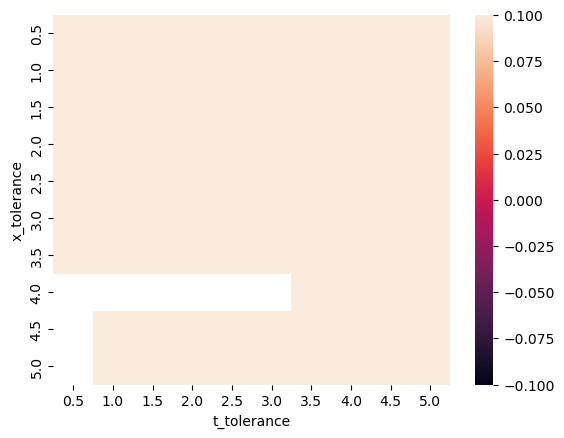

In [67]:
plt.figure()
sns.heatmap(log_medians)
plt.show()

## Varying noise

In [109]:
noises = [0.5*i for i in range(1, 11)]

In [122]:
N = 1000
data = []
t_tol = 5
x_tol = 5
combo = (x_tol, t_tol)

for _ in tqdm(range(N)):
    for noise in noises:
        d = {"x_tolerance": x_tol, "t_tolerance": t_tol, "uncertainty": noise}
        noisy_traces = make_noisy_traces(traces, noise)
        col_points = get_col_points_traces(noisy_traces,
                                           x_tolerance=x_tol,
                                           t_tolerance=t_tol)
        n_col_trial = len(col_points)
        true = original_data[combo]
        d["pc_col_diff"] = (n_col_trial - true) / true * 100
                
        data.append(d)

data = pd.DataFrame(data)

100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.07it/s]


In [123]:
print(true)

164


In [124]:
data.head()

x_tolerance  t_tolerance  uncertainty  pc_col_diff
0            5            5          0.5    -9.756098
1            5            5          1.0     0.000000
2            5            5          1.5    -3.658537
3            5            5          2.0   -18.292683
4            5            5          2.5    -9.756098

<>:4: SyntaxWarning:

invalid escape sequence '\D'

<>:4: SyntaxWarning:

invalid escape sequence '\D'

<>:4: SyntaxWarning:

invalid escape sequence '\D'

<>:4: SyntaxWarning:

invalid escape sequence '\D'

/tmp/ipykernel_178448/862614761.py:4: SyntaxWarning:

invalid escape sequence '\D'

/tmp/ipykernel_178448/862614761.py:4: SyntaxWarning:

invalid escape sequence '\D'



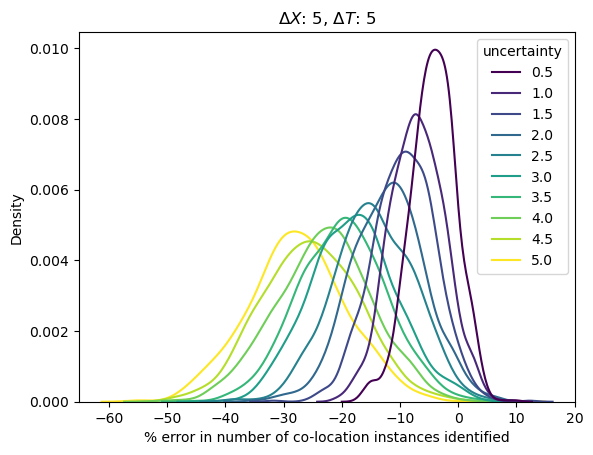

In [125]:
plt.figure()
sns.kdeplot(data=data, x="pc_col_diff", hue="uncertainty", palette="viridis")
plt.xlabel("% error in number of co-location instances identified")
plt.title(f"$\Delta X$: {x_tol}, $\Delta T$: {t_tol}")
plt.savefig(f"figures/x_tol_{x_tol}_t_tol_{t_tol}_noise_{noise}".replace(".", "_") + ".pdf")
plt.show()